In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%matplotlib inline
# %matplotlib notebook
%load_ext autoreload
%autoreload 2


import os,sys 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 3 different slices in each channel

from torch.utils.data import Dataset, DataLoader
import torch
print(torch.cuda.is_available())

from torchvision import transforms
from torchvision import datasets
import natsort
from PIL import *

from torchsummary import summary
import torch
import torch.nn as nn

#import albumentations as A
# cwd = os.getcwd()
# print(cwd)

def showIm(img) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
 
    # <something gets done here>
    plt.figure()
    plt.imshow(img)

def showAll(picList):
    for im in picList:
        plt.figure()
        plt.imshow(im)
    
imgList = []

class SimDataset(Dataset):
    def __init__(self, main_dir, transform=None):
#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.main_dir = main_dir
        self.transform = transform
        self.input_images = os.listdir(main_dir + '/image/')
        self.target_masks = os.listdir(main_dir + '/mask')
        self.input_images = natsort.natsorted(self.input_images)
        self.target_masks = natsort.natsorted(self.target_masks)

    def __len__(self):
        return len(self.input_images)
    
    def _get_prev_next(self, idx, image_list_set, mask_list_set):
        main_slice = self.input_images[idx]
        
        slice_num = int(main_slice[16:19])
        prev_num = slice_num - 1
        next_num = slice_num + 1
        
        prev_num = "%03d" % prev_num
        next_num = "%03d" % next_num
    
        
        prev_slice = prev_num.join([main_slice[0:15], main_slice[19:]])
        next_slice = next_num.join([main_slice[0:15], main_slice[19:]])
        
        if not (prev_slice in image_list_set):
            prev_slice = main_slice
        if not (next_slice in image_list_set):
            next_slice = main_slice
            
#         print(type(self.input_images))
#         print(str(type(main_slice)) + ' ' + main_slice + ' ' + str(slice_num) + ' ' + str(prev_num) + ' ' + str(next_num) + ' ' + prev_slice + ' ' + next_slice)
#         print(main_slice)
#         print()
        return prev_slice, next_slice
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        
        
        image_list_set = set(self.input_images)
        mask_list_set = set(self.target_masks)
        
        prev_slice, next_slice = self._get_prev_next(idx, image_list_set, mask_list_set)
        
        prev_loc = os.path.join(self.main_dir, 'image', prev_slice)
        next_loc = os.path.join(self.main_dir, 'image', next_slice)
        img_loc = os.path.join(self.main_dir, 'image', image)
        mask_loc = os.path.join(self.main_dir, 'mask', mask)

#         image = np.load(img_loc).type(torch.FloatTensor)
#         mask = np.load(mask_loc).type(torch.FloatTensor)
        mid_slice = torch.from_numpy(np.load(img_loc)).type(torch.FloatTensor)
        prev_slice = torch.from_numpy(np.load(prev_loc)).type(torch.FloatTensor)
        next_slice = torch.from_numpy(np.load(next_loc)).type(torch.FloatTensor)
        mask = torch.from_numpy(np.load(mask_loc)).type(torch.FloatTensor)
        
        image_3d = torch.stack([prev_slice, mid_slice, next_slice], dim=0)
        
        #         mask = 1 - mask
        
#         print(image_3d.shape)
#         self._get_prev_next(idx, image_list_set, mask_list_set)
        
        image = np.repeat(image_3d[np.newaxis, :,:], 1, axis=0)
        mask = np.repeat(mask[np.newaxis, :, :], 1, axis=0)
#         image = np.transpose(image, (1, 2, 0))
#         mask = np.transpose(mask, (1, 2, 0))
        
   
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
        
        return [image_3d, mask]


train_dataset_path = 'gdrive/MyDrive/temp_dml/data/train'
val_dataset_path = 'gdrive/MyDrive/temp_dml/data/val'

test_set = SimDataset(
    main_dir=val_dataset_path, 
#     main_dir=train_dataset_path,
    transform=None
)

test_batch_size = 1
test_loader = DataLoader(test_set, batch_size=test_batch_size , shuffle=False, num_workers=0)
inputs, labels = next(iter(test_loader))


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(torch.nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
#        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        #Duplicated to be compatible with DeepLift
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.maxpool3 = nn.MaxPool2d(2)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

#        print("dconv_down1: x.shape")
#        print(x.shape)
        conv1 = self.dconv_down1(x)
        x = self.maxpool1(conv1)

#        print("dconv_down2: x.shape")
#        print(x.shape)
        conv2 = self.dconv_down2(x)
        x = self.maxpool2(conv2)
        
#        print("dconv_down3: x.shape")
#        print(x.shape)
        conv3 = self.dconv_down3(x)
        x = self.maxpool3(conv3)   
        
#        print("dconv_down4: x.shape")
#        print(x.shape)
        x = self.dconv_down4(x)
        
#        print("upsample: x.shape")
#        print(x.shape)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
#        print("dconv_up3: x.shape")
#        print(x.shape)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

#        print("dconv_up2: x.shape")
#        print(x.shape)
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
#        print("dconv_up1: x.shape")
#        print(x.shape)
        x = self.dconv_up1(x)
        
#        print("dconv_up1: x.shape")
#        print(x.shape)
        out = self.conv_last(x)
        
#        print("out: out.shape")
#        print(out.shape)
        
#        return torch.sigmoid(out)
        return out



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_out_class = 1

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# device = torch.device("cpu")
# print(torch.cuda.is_available())
print(device)
# print(next(model.parameters()).is_cuda)

# num_class = 1

model = UNet(1).to(device, dtype=torch.float)

model.load_state_dict(torch.load('gdrive/MyDrive/temp_dml/best_model.pt', map_location='cuda'))

model.eval()   # Set model to evaluate mode

# test_dataset = SimDataset(2, transform = trans)
test_set = SimDataset(
    main_dir='gdrive/MyDrive/temp_dml/data/val', 
#     main_dir=train_dataset_path,
    transform=None
)

test_loader = DataLoader(test_set, batch_size=1 , shuffle=True, num_workers=0)
inputs, labels = next(iter(test_loader))

from numpy import unravel_index
def printImages(entering):
    for im in entering:
        print(np.amin(im), np.amax(im))
        print(im.sum())
        print(unravel_index(im.argmax(), im.shape))
#         unique, counts = np.unique(img, return_counts=True)
#         print(dict(zip(unique, counts)))
        print()
        plt.figure()
        plt.imshow(im)

inputs.requires_grad_()
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import InputXGradient
from captum.attr import GuidedBackprop
from captum.attr import GuidedGradCam
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
from captum.attr import visualization as viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
cuda


In [ ]:
def seg_wrapper1(inp, model, layer, targets):
  pred_out = model(inp)




  
  

  

torch.Size([1, 3, 512, 512])

In [14]:
selected_pixels = []
threshold = 1.8
for i in range(pred_out.shape[0]):
  for j in range(pred_out.shape[1]):
    if pred_out[i, j] >= threshold:
      selected_pixels.append((0, i, j))
len(selected_pixels)

40

In [15]:
dl = DeepLift(model)
attr_dl = dl.attribute(inputs.to(device), target=(0, 367, 317), return_convergence_delta=False)

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [16]:
from captum.attr import LayerDeepLift

In [20]:
dl2 = LayerDeepLift(model, model.dconv_down1)
attr_dl2 = dl2.attribute(inputs.to(device), target=(0, 367, 317), attribute_to_layer_input=True, return_convergence_delta=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [18]:
attr_dl.shape

torch.Size([1, 3, 512, 512])

In [21]:
attr_dl2.shape

torch.Size([1, 3, 512, 512])

In [25]:
attr_dl[0][0:1].shape

torch.Size([1, 512, 512])

In [7]:
pred = model(inputs.to(device))

In [8]:
pred_out = pred[0][0]

In [7]:
temp_pred = pred.sum(dim=(2, 3))

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:419: UserWarning: tight_layout: falling back to Agg renderer
  plt_fig.tight_layout()


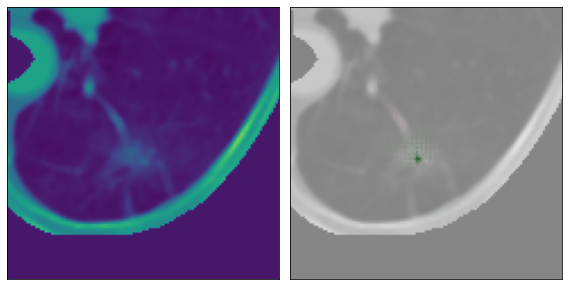

In [101]:
fig, axes = viz.visualize_image_attr_multiple(attr_dl[0][0:1].cpu().permute(1, 2, 0).detach().numpy(), 
                                              original_image=inputs[0][0:1].cpu().permute(1, 2, 0).detach().numpy(),
                                              signs=["all", "all"], methods=["original_image", "blended_heat_map"],
                                              use_pyplot=False)
for axis in axes:
  axis.set_xlim([260, 380])
  axis.set_ylim([420, 300])
fig

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:419: UserWarning: tight_layout: falling back to Agg renderer
  plt_fig.tight_layout()


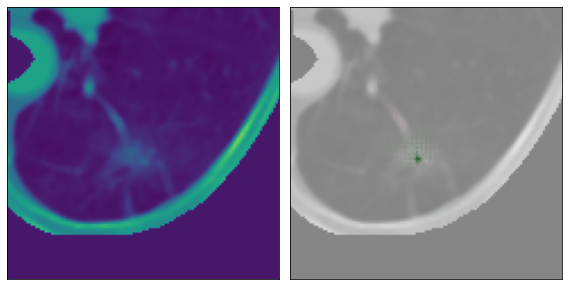

In [105]:
fig, axes = viz.visualize_image_attr_multiple(attr_dl2[0][0:1].cpu().permute(1, 2, 0).detach().numpy(), 
                                              original_image=inputs[0][0:1].cpu().permute(1, 2, 0).detach().numpy(),
                                              signs=["all", "all"], methods=["original_image", "blended_heat_map"],
                                              use_pyplot=False)
for axis in axes:
  axis.set_xlim([260, 380])
  axis.set_ylim([420, 300])
  axis.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
fig

In [92]:
plt.show()

In [53]:
axis[0].set_xlim([1, 10])
axis[0].show()

AttributeError: ignored

In [71]:
a = axis[0]

In [87]:
a.get_xticklabels()

<a list of 6 Text major ticklabel objects>

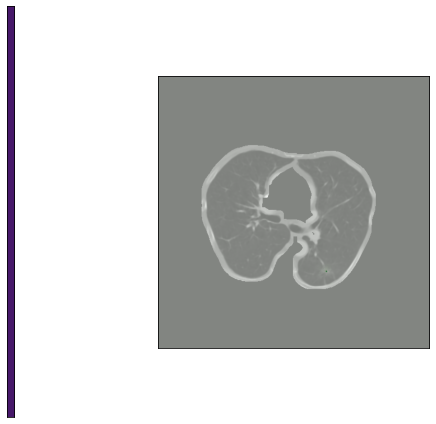

In [86]:
fig

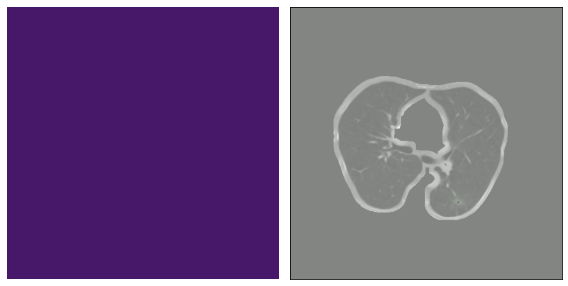

In [77]:
fig

In [62]:
a.
fig

TypeError: ignored

In [42]:
fig.show()

In [22]:
plt.show()

In [ ]:
#Integrated Gradients
ig = IntegratedGradients(model)
attr_ig = ig.attribute(inputs.to(device),target=(0, 367, 317), internal_batch_size=10, return_convergence_delta=False)

In [ ]:
dl = DeepLift(model)

In [ ]:
dl = DeepLift(model)
attr_dl = dl.attribute(inputs.to(device), target=(0, 367, 317), return_convergence_delta=False)

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Trigger

In [ ]:
def dl_map(model, targets):
  maps = list()
  for target in targets:
    maps.append(np.mean(dl.attribute(inputs.to(device), target=target, return_convergence_delta=False).detach().cpu().numpy()[0], 0, keepdims=True)[0])
  return np.array(maps)

In [ ]:
def ig_map(model, targets):
  maps = list()
  for target in targets:
    maps.append(np.mean(ig.attribute(inputs.to(device), target=target, internal_batch_size=10, return_convergence_delta=False).detach().cpu().numpy()[0], 0, keepdims=True)[0])
  return np.array(maps)

In [ ]:
i = np.mean(inputs[0].detach().cpu().numpy(), 0, keepdims=True)[0]

In [ ]:
pred_out = model(inputs.to(device))[0, 0].detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
selected_pixels = []
threshold = 0.4
for i in range(pred_out.shape[0]):
  for j in range(pred_out.shape[1]):
    if pred_out[i, j] >= threshold:
      selected_pixels.append((0, i, j))
len(selected_pixels)

190

In [ ]:
a = dl_map(model, selected_pixels)

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
b = np.mean(a, 0, keepdims=True)

(420.0, 300.0)

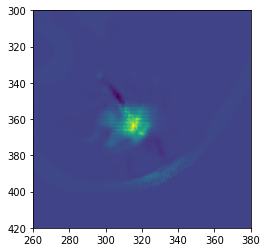

In [ ]:
plt.imshow(b[0]*500 + i*0.1)
plt.xlim([260, 380])
plt.ylim([420, 300])

In [ ]:
from matplotlib.colors import colorConverter

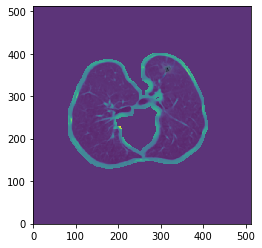

In [ ]:
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['green','blue'],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

img2 = plt.imshow(i, interpolation='nearest', cmap=cmap1, origin='lower')
img3 = plt.imshow(b[0], interpolation='nearest', cmap=cmap2, origin='lower')

plt.show()

In [ ]:
z = np.zeros([512, 512])
for i in selected_pixels:
  z[i] = 1

(380.0, 320.0)

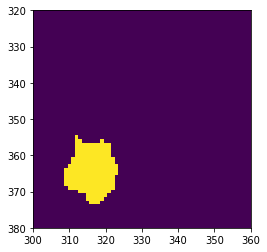

In [ ]:
plt.imshow(z)
plt.xlim([300, 360])
plt.ylim([380, 320])

In [ ]:
mask = labels[0, 0].detach().cpu().numpy()

In [ ]:
for i in range(mask.shape[0]):
  for j in range(mask.shape[1]):
    if mask[i, j] != 0 and mask[i, j] != 1:
      print(f"({i}, {j}): {mask[i, j]}")

In [ ]:
a = ig_map(model, [(0, 367, 317), (0, 363, 325)])

In [ ]:
inputs.shape

torch.Size([1, 3, 512, 512])

In [ ]:
j = np.array([])

In [ ]:
j = np.append(j, np.mean(attr_dl.detach().cpu().numpy()[0], 0, keepdims=True)[0], axis=0)

ValueError: ignored

In [ ]:
j

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
np.mean(attr_dl.detach().cpu().numpy()[0], 0, keepdims=True)[0].shape

(512, 512)

In [ ]:
j.append(attr_dl)

In [ ]:
i = inputs[0].detach().cpu().numpy()

In [ ]:
np.mean(i, 0, keepdims=True)[0].shape

(512, 512)

In [ ]:
i = np.mean(i, 0, keepdims=True)[0]

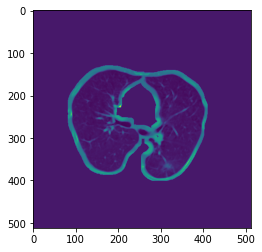

In [ ]:
plt.imshow(i)

In [ ]:
i = inputs[0, 0].detach().cpu().numpy()

In [ ]:
a = attr_dl[0, 0].detach().cpu().numpy()

In [ ]:
np.max(a)

0.04363187

In [ ]:
np.min(a)

-0.008073236

In [ ]:
np.mean(a)

3.9400643e-06

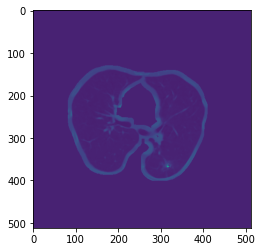

In [ ]:
plt.imshow(i*0.5 + a*100)

In [ ]:
attr_ig2 = ig.attribute(inputs.to(device),target=(0, 366, 317), internal_batch_size=10, return_convergence_delta=False)

In [ ]:
attr_ig3 = ig.attribute(inputs.to(device),target=, internal_batch_size=10, return_convergence_delta=False)

AssertionError: ignored

In [ ]:
attr_ig[0].shape

torch.Size([3, 512, 512])

In [ ]:
jo = (attr_ig+attr_ig2)/2

In [ ]:
jo.shape

torch.Size([1, 3, 512, 512])

In [ ]:
import torch
import torch.nn as nn
import pytorch_unet

cuda:0


In [ ]:
pred = model(inputs.to(device))

In [ ]:
pred2 = model(inputs.to(device))

In [ ]:
False in (pred == pred2)

False

In [ ]:
    img_num = 0
    test_image = inputs.cpu()[img_num][0].numpy()
    test_mask = labels.cpu()[img_num][0].numpy()

    inputs = inputs.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)
#     pred = F.sigmoid(pred)

    pred = model(inputs)
    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    # pred = pred.data.cpu()



    predImg = pred[img_num][0]
    predMask = np.where(predImg > mask_prob, 1, 0)

    imgs = []
    imgs.append(test_image)
    imgs.append(test_mask)
    imgs.append(predMask)
    outputs.append(predMask)
    imgs.append(predImg)
    printImages(imgs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


NameError: ignored

In [ ]:
inputs[0:1].shape == inputs.shape

True

In [ ]:
pred = model(inputs.to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


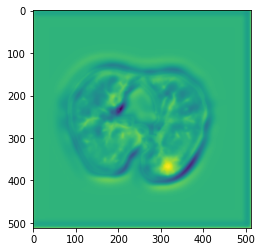

In [ ]:
plt.imshow(pred[0, 0].data.cpu().numpy())

In [ ]:
pred = pred.data.cpu().numpy()

-29.650944 5.197756
-2023022.4
(367, 317)



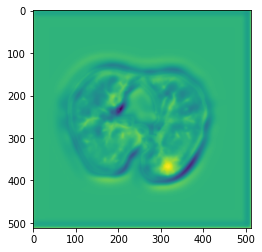

In [ ]:
printImages(pred[0])

In [ ]:
pred[0][0, 365, 317]

5.003705

In [ ]:
pred2 = np.where(predImg > mask_prob, 1, 0)

     |████████████████████████████████| 1.4 MB 8.8 MB/s 


In [ ]:
ig = IntegratedGradients(model)

In [ ]:
inputs.requires_grad_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], requires_grad=True)

In [ ]:
attr = ig.attribute(inputs.to(device),target=(0, 367, 317), internal_batch_size=1, return_convergence_delta=False)

RuntimeError: ignored

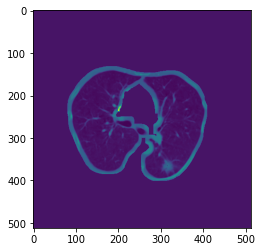

In [ ]:
plt.imshow(inputs[0][0])

In [ ]:
False in (attr == 0)

True

In [ ]:
attr[0, 0] == 0

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

(320.0, 400.0)

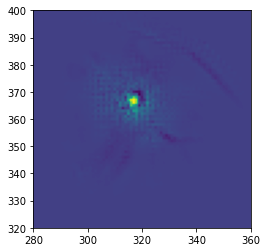

In [ ]:
plt.imshow(attr[0, 0])
plt.xlim([280, 360])
plt.ylim([320, 400])

Text(0.5, 1.0, 'Interpretability')

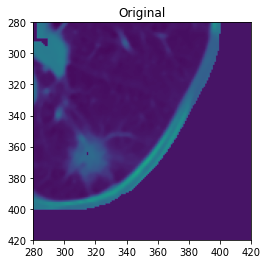

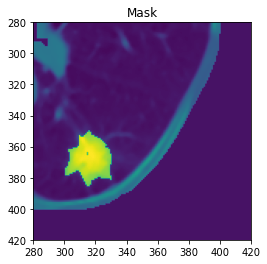

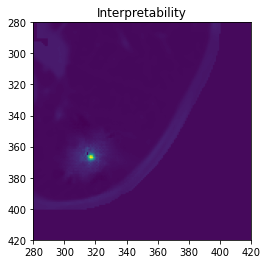

In [ ]:
plt.figure()
plt.imshow(inputs[0, 0])
plt.xlim([280, 420])
plt.ylim([420, 280])
plt.title("Original")
plt.figure()
plt.imshow(labels[0, 0]*3 + inputs[0, 0])
plt.xlim([280, 420])
plt.ylim([420, 280])
plt.title("Mask")
plt.figure()
plt.imshow(attr[0, 1]*100 + inputs[0, 0]*0.5)
plt.xlim([280, 420])
plt.ylim([420, 280])
plt.title("Interpretability")

(380.0, 360.0)

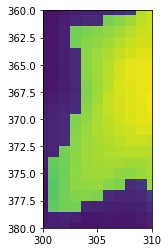

In [ ]:
plt.imshow(labels[0, 0]*3 + inputs[0, 0])
plt.xlim([300, 310])
plt.ylim([380, 360])

In [ ]:
attr2 = ig.attribute(inputs,target=(0, 375, 300), internal_batch_size=1, return_convergence_delta=True)

In [ ]:
plt.imshow(attr2[0, 0])
plt.xlim([280, 360])
plt.ylim([320, 400])

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
attr2, delta = attr2

(320.0, 420.0)

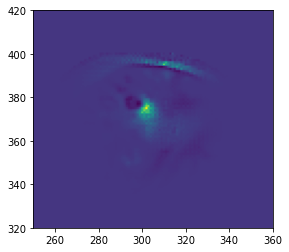

In [ ]:
plt.imshow(attr2[0, 1])
plt.xlim([250, 360])
plt.ylim([320, 420])

Text(0.5, 1.0, 'Interpretability')

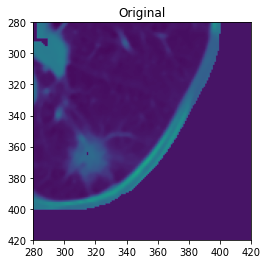

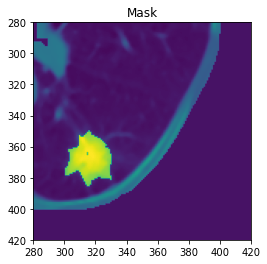

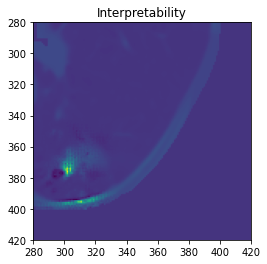

In [ ]:
plt.figure()
plt.imshow(inputs[0, 0])
plt.xlim([280, 420])
plt.ylim([420, 280])
plt.title("Original")
plt.figure()
plt.imshow(labels[0, 0]*3 + inputs[0, 0])
plt.xlim([280, 420])
plt.ylim([420, 280])
plt.title("Mask")
plt.figure()
plt.imshow(attr2[0, 2]*500 + inputs[0, 0])
plt.xlim([280, 420])
plt.ylim([420, 280])
plt.title("Interpretability")